# 分析句子的意思

1. 我们如何能表示自然语言的意思，使计算机能够处理这些表示？

2. 我们怎样才能将意思表示与无限的句子集合关联？

3. 我们怎样才能使用连接意思表示与句子的程序来存储知识？

## 自然语言理解
### 查询数据库

In [1]:
import nltk
nltk.data.show_cfg('grammars/book_grammars/sql0.fcfg')

% start S
S[SEM=(?np + WHERE + ?vp)] -> NP[SEM=?np] VP[SEM=?vp]
VP[SEM=(?v + ?pp)] -> IV[SEM=?v] PP[SEM=?pp]
VP[SEM=(?v + ?ap)] -> IV[SEM=?v] AP[SEM=?ap]
NP[SEM=(?det + ?n)] -> Det[SEM=?det] N[SEM=?n]
PP[SEM=(?p + ?np)] -> P[SEM=?p] NP[SEM=?np]
AP[SEM=?pp] -> A[SEM=?a] PP[SEM=?pp]
NP[SEM='Country="greece"'] -> 'Greece'
NP[SEM='Country="china"'] -> 'China'
Det[SEM='SELECT'] -> 'Which' | 'What'
N[SEM='City FROM city_table'] -> 'cities'
IV[SEM=''] -> 'are'
A[SEM=''] -> 'located'
P[SEM=''] -> 'in'


In [8]:
#创建查询语句
from nltk import load_parser
cp = load_parser('grammars/book_grammars/sql0.fcfg', trace=3)
query = 'What cities are located in China'
trees = list(cp.parse(query.split()))
answer = trees[0].label()['SEM']#理解这里的循环 SEM 如何建立 SEM 的值
answer = [s for s in answer if s]
q = ' '.join(answer)
print(q)

|.W.c.a.l.i.C.|
Leaf Init Rule:
|[-] . . . . .| [0:1] 'What'
|. [-] . . . .| [1:2] 'cities'
|. . [-] . . .| [2:3] 'are'
|. . . [-] . .| [3:4] 'located'
|. . . . [-] .| [4:5] 'in'
|. . . . . [-]| [5:6] 'China'
Feature Bottom Up Predict Combine Rule:
|[-] . . . . .| [0:1] Det[SEM='SELECT'] -> 'What' *
Feature Bottom Up Predict Combine Rule:
|[-> . . . . .| [0:1] NP[SEM=(?det+?n)] -> Det[SEM=?det] * N[SEM=?n] {?det: 'SELECT'}
Feature Bottom Up Predict Combine Rule:
|. [-] . . . .| [1:2] N[SEM='City FROM city_table'] -> 'cities' *
Feature Single Edge Fundamental Rule:
|[---] . . . .| [0:2] NP[SEM=(SELECT, City FROM city_table)] -> Det[SEM='SELECT'] N[SEM='City FROM city_table'] *
Feature Bottom Up Predict Combine Rule:
|[---> . . . .| [0:2] S[SEM=(?np+WHERE+?vp)] -> NP[SEM=?np] * VP[SEM=?vp] {?np: (SELECT, City FROM city_table)}
Feature Bottom Up Predict Combine Rule:
|. . [-] . . .| [2:3] IV[SEM=''] -> 'are' *
Feature Bottom Up Predict Combine Rule:
|. . [-> . . .| [2:3] VP[SEM=(?v+?pp)] 

In [10]:
#我们在数据库 city.db 上执行查询
from __future__ import print_function
from nltk.sem import chat80
rows = chat80.sql_query('corpora/city_database/city.db', q)
for r in rows: 
    print(r[0], end=" ")

canton chungking dairen harbin kowloon mukden peking shanghai sian tientsin 

## 命题逻辑

In [22]:
# read_expr = nltk.sem.Expression.fromstring
# lp = nltk.sem.Expression.fromstring
# SnF = read_expr('SnF')
# NotFnS = read_expr('-FnS')
# R = read_expr('SnF -> -FnS')
# prover = nltk.Prover9()
# prover.prove(NotFnS, [SnF, R])

In [11]:
nltk.boolean_ops()

negation       	-
conjunction    	&
disjunction    	|
implication    	->
equivalence    	<->


In [16]:
#真值赋值
val = nltk.Valuation([('P', True), ('Q', True), ('R', False)])
val['P']

True

In [17]:
#暂时的，在下面的声明中先忽略参数dom和g
dom = set([])
g = nltk.Assignment(dom)
#让我们用val初始化模型m
m = nltk.Model(dom, val)

In [19]:
print(m.evaluate('(P & Q)', g))

True


In [23]:
print(m.evaluate('-(P & Q)', g))

False


In [24]:
print(m.evaluate('(P & R)', g))

False


## 一阶逻辑
我们将通过翻译自然语言表达式为一阶逻辑来表示它们的意思。并不
是所有的自然语言语义都可以用一阶逻辑表示。但它是计算语义的一个不错的选择，因为它
具有足够的表现力来表达语义的很多方面，而且另一方面，有出色的现成系统可用于开展一
阶逻辑自动推理。

下一步我们将描述如何构造一阶逻辑公式，然后是这样的公式如何用来评估模型。
### 句法
例如，Angus walks可以被形式化为walk(angus)，Angus sees Bertie可以被形式化为see(angus, bertie)。我们称walk为一元谓词，see为二元谓词。

In [26]:
read_expr = nltk.sem.Expression.fromstring
expr = read_expr('walk(angus)', type_check=True)
expr.argument

<ConstantExpression angus>

In [27]:
expr.argument.type

e

In [28]:
expr.function

<ConstantExpression walk>

In [29]:
expr.function.type

<e,?>

In [34]:
'''
我们需要指定一个信
号，作为一个字典来实施，明确的与非逻辑常量类型关联：
'''
sig = {'walk': '<e, t>'}
expr = read_expr('walk(angbs)', signature=sig)
expr.function.type

e

In [36]:
# ((exists x. dog(x)) -> bark(x))

## 一阶定理证明
all x. all y.(north_of(x, y) -> -north_of(y, x))
更妙的是，我们可以进行自动推理来证明论证的有效性。
定理证明在一般情况下是为了确定我们要证明的公式（证明目标）是否可以由一个有限
序列的推理步骤从一个假设的公式列表派生出来。我们写作 A g，其中 A 是一个假设的
列表（可能为空），g 是证明目标。我们将用 NLTK 中的定理证明接口 Prover9 来演示这个。
首先，我们分析所需的证明目标�和两个��。然后我们创建一个 Prover9 实例④，并在目
标和给定的假设列表上调用它的 prove()⑤。

NotFnS = lp.parse('-north_of(f, s)') �

SnF = lp.parse('north_of(s, f)') �

R = lp.parse('all x. all y. (north_of(x, y) -> -north_of(y, x))') �
 
 prover = nltk.Prover9() ④

prover.prove(NotFnS, [SnF, R]) ⑤

True

## 一阶逻辑语言总结

In [37]:
dom = {'b', 'o', 'c'}
v = """
 bertie => b
 olive => o
 cyril => c
 boy => {b}
 girl => {o}
 dog => {c}
 walk => {o, c}
 see => {(b, o), (c, b), (o, c)}
 """

In [63]:
'''
dom 值 b o c

以下各种symbol都有值的属性

'''
print

<function print>

In [38]:
#我们使用工具函数Valuation.fromstring()将 symbol => value形式的字符串序列转换成一个Valuation对象。
val = nltk.Valuation.fromstring(v)
print (val)

{'boy': set([('b',)]), 'cyril': 'c', 'dog': set([('c',)]), 'walk': set([('c',), ('o',)]), 'bertie': 'b', 'see': set([('o', 'c'), ('c', 'b'), ('b', 'o')]), 'olive': 'o', 'girl': set([('o',)])}


## 独立变量和赋值

In [39]:
#以(变量,值)的形式来绑定
g = nltk.Assignment(dom, [('x', 'o'), ('y', 'c')])

In [40]:
g

{'y': 'c', 'x': 'o'}

In [41]:
print (g)

g[c/y][o/x]


In [42]:
# 首先，我们创建了一个模型，然后调用evaluate()方法来计算真值
m = nltk.Model(dom, val)
m.evaluate('see(olive, y)', g)

True

In [43]:
'''
然而，当解释函数遇到变量y时，不是检查val中的值，它在变量赋值g中查询这个变量的值：
'''
g['y']

'c'

In [45]:
# 在这种情况下，我们可以说赋值g满足公式see(olive, y)
m.evaluate('see(x, y)', g)

True

In [46]:
m.evaluate('see(y, x)', g)

False

In [47]:
#组合评估、模型检查
m.evaluate('see(bertie, olive) & boy(bertie) & -walk(bertie)', g)

True

## 量化
现代逻辑的关键特征之一就是变量满足的概念可以用来解释量化的公式。让我们用（2

4）作为一个例子。

(24) exists x.(girl(x) & walk(x))

什么时候为真？让我们想想我们的域，即在 dom 中的所有个体。我们要检查这些个体

中是否有属性是女孩并且这种走路的。换句话说，我们想知道 dom 中是否有某个 u 使 g[u

/x]满足开放的公式(25)。

(25) girl(x) & walk(x)

思考下面的：

In [48]:
m.evaluate('exists x.(girl(x) & walk(x))', g)

True

In [49]:
'''
在这里 evaluate()返回 True，因为 dom 中有某些 u 通过绑定 x 到 u 的赋值满足（2
5）。事实上，o 是这样一个 u：
'''
m.evaluate('girl(p) & walk(p)', g.add('p', 'o'))

True

In [51]:
print (g)

g[c/y][o/p][o/x]


In [52]:
'''
NLTK 中提供了一个有用的工具：satisfiers()方法。它返回满足开放公式的所有个体
的集合。该方法的参数是一个已分析的公式、一个变量和一个赋值。
'''
fmla1 = read_expr('girl(x) | boy(x)')
m.satisfiers(fmla1, 'x', g)

{'b', 'o'}

In [57]:
fmla2 = read_expr('girl(t) -> walk(t)')
m.satisfiers(fmla2, 't', g)

{'b', 'c', 'o'}

In [ ]:
'''
->的真值条件的意思是fmla2等价于-girl(x) | walk(x)
'''

In [58]:
fmla3 = read_expr('walk(x) -> girl(x)')
m.satisfiers(fmla3, 'x', g)

{'b', 'o'}

In [60]:
fmla4 = read_expr('walk(x)')
m.satisfiers(fmla4, 'x', g)

{'c', 'o'}

In [72]:
m.evaluate('all x.(girl(x)-> walk(x))', g)

True

In [78]:
fmla5 = read_expr('girl(x)&walk(x)')
m.satisfiers(fmla5,'x',g)

{'o'}

In [79]:
m.evaluate('all x.(girl(x) & walk(x))', g)

False

## 量词范围歧义

In [80]:
v2 = """
 bruce => b
 elspeth => e
 julia => j
 matthew => m
 person => {b, e, j, m}
 admire => {(j, b), (b, b), (m, e), (e, m)}
"""
val2 = nltk.Valuation.fromstring(v2)

In [81]:
dom2 = val2.domain
m2 = nltk.Model(dom2, val2)
g2 = nltk.Assignment(dom2)#绑定
fmla4 = read_expr('(person(x) -> exists y.(person(y) & admire(x, y)))')
m2.satisfiers(fmla4, 'x', g2)

{'b', 'e', 'j', 'm'}

In [82]:
#也就是说，没有大家都钦佩的人。
fmla5 = read_expr('(person(y) & all x.(person(x) -> admire(x, y)))')
m2.satisfiers(fmla5, 'y', g2)

set()

In [83]:
# 看看另一个开放的公式fmla6，我们可以验证有一个人，即Bruce，它被Julia和Bruce都钦佩。
fmla6 = read_expr('(person(y) & all x.((x = bruce | x = julia) -> admire(x, y)))')
m2.satisfiers(fmla6, 'y', g2)

{'b'}

## 模型的建立

In [84]:
# 我们通过创建 Mace()的一个实例并调用它的 build_model()方法来调用 Mace4 模式产生器
a3 = read_expr('exists x.(man(x) & walks(x))')
c1 = read_expr('mortal(socrates)')
c2 = read_expr('-mortal(socrates)')
mb = nltk.Mace(5)#

In [86]:
# print(mb.build_model(None, [a3, c1]))
# >>> print mb.build_model(None, [a3, c1])
# True
# >>> print mb.build_model(None, [a3, c2])
# True
# >>> print mb.build_model(None, [c1, c2])
# False

In [97]:
# >>> a4 = read_expr('exists y. (woman(y) & all x. (man(x) -> love(x,y)))')
# >>> a5 = read_expr('man(adam)')
# >>> a6 = read_expr('woman(eve)')
# >>> g = read_expr('love(adam,eve)')
# >>> mc = nltk.MaceCommand(g, assumptions=[a4, a5, a6])
# >>> mc.build_model()

## 英语句子的语义、拉姆达演算

In [98]:
read_expr = nltk.sem.Expression.fromstring
expr = read_expr(r'\x.(walk(x) & chew_gum(x))')

In [99]:
expr

<LambdaExpression \x.(walk(x) & chew_gum(x))>

In [100]:
expr.free()

set()

In [101]:
print(read_expr(r'\x.(walk(x) & chew_gum(y))'))

\x.(walk(x) & chew_gum(y))


In [102]:
print(read_expr(r'\x.\y.(dog(x) & own(y, x))(cyril)').simplify())#两个lamda简化

\y.(dog(cyril) & own(y,cyril))


In [104]:
print(read_expr(r'\x.\y.(dog(x) & own(y, x))(cyril)'))#两个lamda

(\x y.(dog(x) & own(y,x)))(cyril)


In [107]:
print(read_expr(r'\x y.(dog(x) & own(y, x))(cyril)').simplify())#两个lamda缩写

\y.(dog(cyril) & own(y,cyril))


In [108]:
print(read_expr(r'\x y.(dog(x) & own(y, x))(cyril,jessi)').simplify())#两个lamda缩写

(dog(cyril) & own(jessi,cyril))


In [105]:
print(read_expr(r'\x.(walk(x) & chew_gum(x)) (gerald)'))#lamda抽象

\x.(walk(x) & chew_gum(x))(gerald)


In [106]:
print(read_expr(r'\x.(walk(x) & chew_gum(x))(gerald)').simplify())#beta简约

(walk(gerald) & chew_gum(gerald))


In [111]:
expr3 = read_expr('\P.(exists x.P(x))(\y.see(y, x))')
print (expr3)

(\P.exists x.P(x))(\y.see(y,x))


In [112]:
print(expr3.simplify())

exists z1.see(z1,x)


In [118]:
#我们所有的λ-抽象到目前为止只涉及熟悉的一阶变量：x、y 等——类型 e 的变量
expr4 = read_expr(r'\y.y(angus)(\x.walk(x))')
print (expr4)

LogicalExpressionException: 'y' is an illegal predicate name.  Individual variables may not be used as predicates.
\y.y(angus)(\x.walk(x))
   ^

In [117]:
'''
让我们用 P 和 Q 作
为<e, t>类型的变量，那么我们可以有一个抽象，如：\P.P(angus)。由于 P 是<e, t>类
型，整个抽象是<<e, t>, t>类型
'''
expr5 = read_expr(r'\P.P(angus)(\x.walk(x))')
print (expr5)

\P.P(angus)(\x.walk(x))


## 量化的 NP
我们如何给量化的 NP：a dog 一个语义表示，使它可以在（42b）中的结果中与
bark 结合？作为第一步，让我们将主语的 SEM 值作为函数表达式，而不是参数（这有时
被称为类型提升。）。现在，我们寻找实例化?np 的方式，使[SEM=<?np(\x.bark(x))>]
等价于[SEM=<exists x.(dog(x) & bark(x))>]。这是否看上去有点让人联想到λ-演算
中的β-约减？换句话说，我们想要一个λ-术语 M 来取代?np，从而应用 M 到\x.bark(x)
产生（42b）。

要做到这一点，我们替代（42b）中出现的\x.bark(x)为一个谓词变量 P，并
用λ绑定变量，如（43）中所示。

In [120]:
'''
'P'而不是'x'或'y'——表明我
们在不同类型的对象上抽象——不是单个个体，而是类型为<e,t>的函数表达式。因此，作
为一个整体（43）的类型是<<e,t>,t>。我们将普遍把这个作为 NP 的类型。
'''
# \P.exists x.(dog(x) & P(x))
print

<function print>

In [124]:
# \P.all x.(dog(x) -> P(x))
'''
现在我们几乎完成了，除了我们还需要进行进一步的抽象，加上将限定词 a
'''
# \Q P.exists x.(Q(x) & P(x))
print

<function print>

In [126]:
'''
Angus chases a dog
\y.exists x.(dog(x) & chase(y, x))
\P.exists x.(dog(x) & P(x))(\z.chase(y, z))
这个其实是等效的，进行了beta简约
'''
read_expr = nltk.sem.Expression.fromstring
tvp = read_expr(r'\X x.X(\y.chase(x,y))')
np = read_expr(r'(\P.exists x.(dog(x) & P(x)))')
vp = nltk.sem.ApplicationExpression(tvp, np)
print(vp)

(\X x.X(\y.chase(x,y)))(\P.exists x.(dog(x) & P(x)))


In [127]:
print(vp.simplify())

\x.exists z2.(dog(z2) & chase(x,z2))


In [128]:
from nltk import load_parser
parser = load_parser('grammars/book_grammars/simple-sem.fcfg', trace=0)
sentence = 'Angus gives a bone to every dog'
tokens = sentence.split()
for tree in parser.parse(tokens):
    print(tree.label()['SEM'])

all z4.(dog(z4) -> exists z3.(bone(z3) & give(angus,z3,z4)))


In [129]:
'''
函数interpret_sents()用于批量解释输入句子的列表。
它建立一个字典d，其中对每个输入的句子sent，
d[sent]是包含sent的分析树和语义表示的(synrep, semrep)对的列表。
'''
sents = ['Irene walks', 'Cyril bites an ankle']
grammar_file = 'grammars/book_grammars/simple-sem.fcfg'
for results in nltk.interpret_sents(sents, grammar_file):
    for (synrep, semrep) in results:
        print(synrep)

(S[SEM=<walk(irene)>]
  (NP[-LOC, NUM='sg', SEM=<\P.P(irene)>]
    (PropN[-LOC, NUM='sg', SEM=<\P.P(irene)>] Irene))
  (VP[NUM='sg', SEM=<\x.walk(x)>]
    (IV[NUM='sg', SEM=<\x.walk(x)>, TNS='pres'] walks)))
(S[SEM=<exists z5.(ankle(z5) & bite(cyril,z5))>]
  (NP[-LOC, NUM='sg', SEM=<\P.P(cyril)>]
    (PropN[-LOC, NUM='sg', SEM=<\P.P(cyril)>] Cyril))
  (VP[NUM='sg', SEM=<\x.exists z5.(ankle(z5) & bite(x,z5))>]
    (TV[NUM='sg', SEM=<\X x.X(\y.bite(x,y))>, TNS='pres'] bites)
    (NP[NUM='sg', SEM=<\Q.exists x.(ankle(x) & Q(x))>]
      (Det[NUM='sg', SEM=<\P Q.exists x.(P(x) & Q(x))>] an)
      (Nom[NUM='sg', SEM=<\x.ankle(x)>]
        (N[NUM='sg', SEM=<\x.ankle(x)>] ankle)))))


In [132]:
'''
现在我们已经看到了英文句子如何转换成逻辑形式，
前面我们看到了在模型中如何检查逻辑形式的真假。
把这两个映射放在一起，我们可以检查一个给定的模型中的英语句子的真值。

让我们看看前面定义的模型m。工具evaluate_sents()类似于interpret_sents()，
除了我们需要传递一个模型和一个变量赋值作为参数。输出是三元组(synrep, semrep, value)，
其中synrep、semrep和以前一样，value是真值。
'''
v = """
 bertie => b
 olive => o
 cyril => c
 boy => {b}
 girl => {o}
 dog => {c}
 walk => {o, c}
 see => {(b, o), (c, b), (o, c)}
"""
val = nltk.Valuation.fromstring(v)
g = nltk.Assignment(val.domain)
m = nltk.Model(val.domain, val)

sent = 'Cyril sees every boy'
grammar_file = 'grammars/book_grammars/simple-sem.fcfg'
results = nltk.evaluate_sents([sent], grammar_file, m, g)[0]
for (syntree, semrep, value) in results:
    print(semrep)
    print(value)

all z7.(boy(z7) -> see(cyril,z7))
True


## 再述量词歧义
要解决的问题是我们如何建立一个核心+存储表示的组合

如前所述，文法中每个短语和词法规则将有一个 SEM 特征，但现在将有嵌入特征 CORE 和 STORE

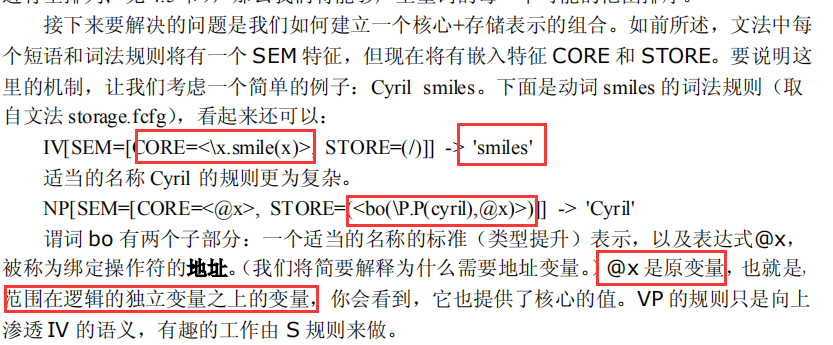

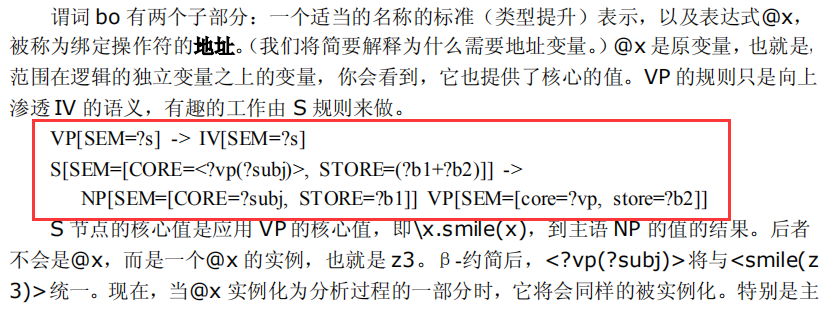

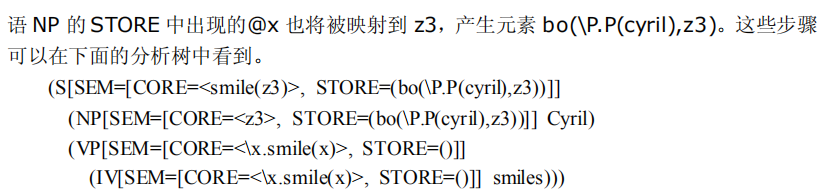

## 段落语义层
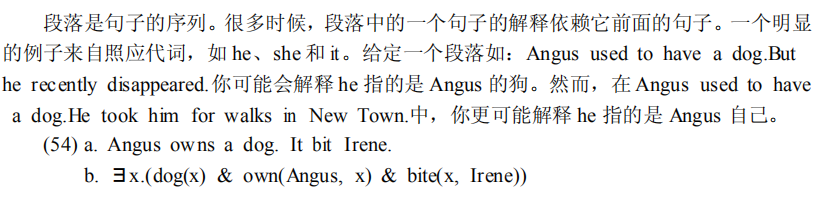

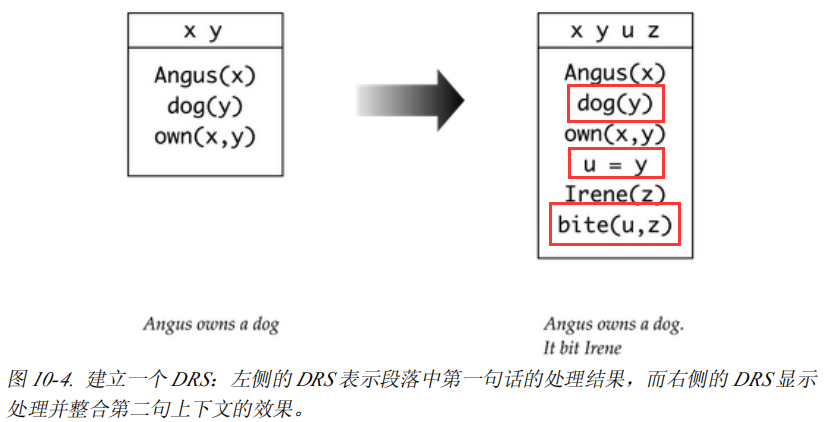

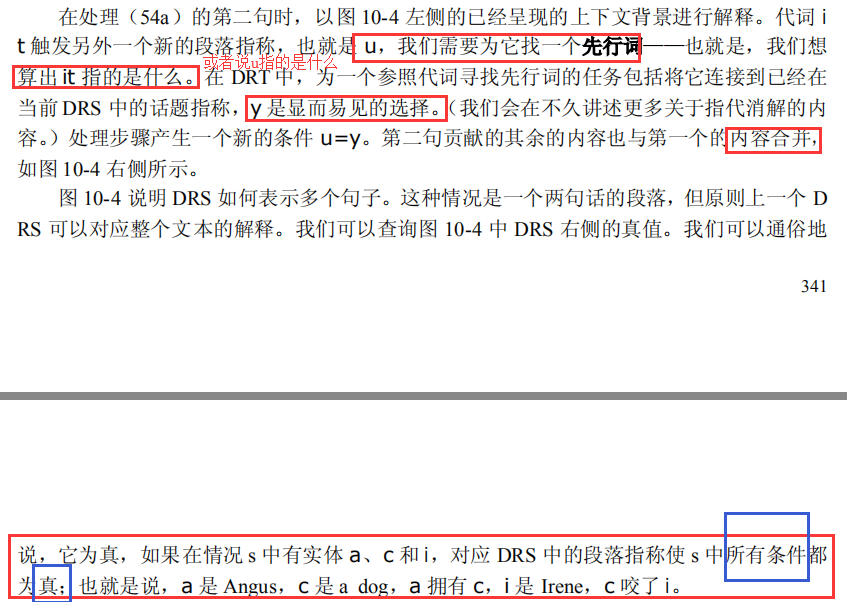

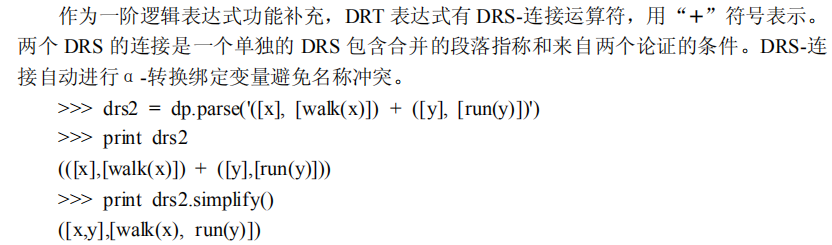

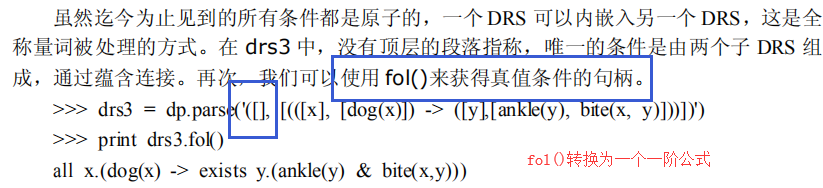

模块 nltk.sem.drt_resolve_anaphora 采用了类此的保守
策略：如果DRS包含PRO(x)形式的条件，方法resolve_anaphora()将其替换为x = [...]
形式的条件，其中[...]是一个可能的先行词链表

drs4 = dp.parse('([x, y], [angus(x), dog(y), own(x, y)])')

drs5 = dp.parse('([u, z], [PRO(u), irene(z), bite(u, z)])')

drs6 = drs4 + drs5

print drs6.simplify()

    ([x,y,u,z],[angus(x), dog(y), own(x,y), PRO(u), irene(z), bite(u,z)]

print drs6.simplify().resolve_anaphora()

    ([x,y,u,z],[angus(x), dog(y), own(x,y), (u = [x,y,z]), irene(z), bite(u,z)]